### SCADA (BATADAL)

### Import modules 

In [1]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras callbacks
from keras.layers import *
# from keras.models import Model, load_model
# from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

# other
import time


# AutoEncoders for Event Detection
from aeed import AEED, load_AEED

In [2]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [3]:
def classification_metrics(label_arr, pred_arr):
    """Return evaluation metrics for binary classification

    Args:
        label_arr: array stored the binary labels
        pred_arr: array stored the binary predictions

    Returns:
        [type]: [description]
    """
    tn, fp, fn, tp = confusion_matrix(np.array(label_arr), np.array(pred_arr)).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)  # true positive
    f1 = (2 * precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    specificity = tn / (tn + fp)  # true negative

    return precision, recall, f1, accuracy, specificity

### Load and preprocess training data

# 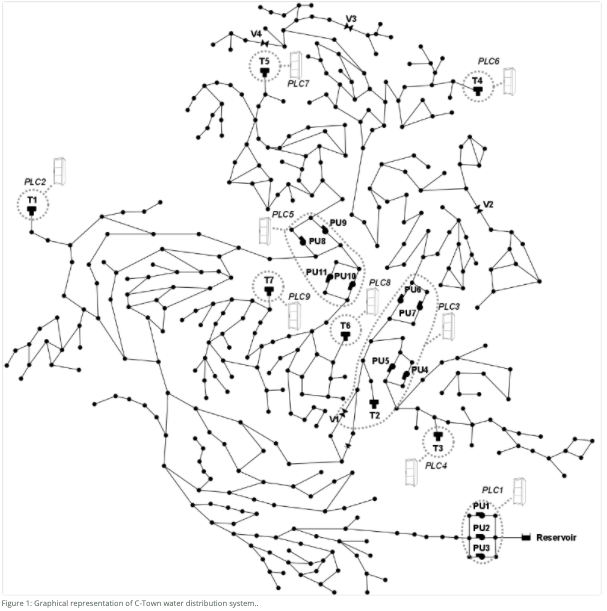

In [20]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_train_orig.head(2)

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,2014-01-06 00:00:00,0.50973,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,2014-01-06 01:00:00,0.41258,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0


In [21]:
df_train_orig.iloc[1450:1920]

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
1450,2014-03-07 10:00:00,4.419439,3.589974,3.163183,2.452763,1.719854,5.500000,3.997245,112.891937,1,...,69.840347,26.576143,84.283440,22.259289,81.986298,22.150290,70.927460,38.348930,27.990288,0
1451,2014-03-07 11:00:00,4.291474,2.848255,3.254893,2.550717,2.113219,5.500000,4.321405,113.439941,1,...,88.553795,22.969578,84.086334,22.069086,82.306892,21.961239,71.304123,38.064274,24.648268,0
1452,2014-03-07 12:00:00,4.138301,1.993436,3.743685,2.797567,2.525909,5.500000,4.669425,113.773788,1,...,88.449829,22.220129,84.317772,21.981474,83.398170,21.872393,70.609039,37.868271,23.888292,0
1453,2014-03-07 13:00:00,3.986867,1.148917,4.217056,3.089585,3.076472,5.473872,4.677205,112.896393,1,...,88.372101,21.436382,83.717789,28.210421,86.715591,28.210421,58.805313,38.290024,23.098747,0
1454,2014-03-07 14:00:00,4.017957,0.309936,4.676427,3.222577,3.756922,5.132442,3.104563,117.375168,1,...,88.300011,25.002348,84.702904,26.060383,84.786156,26.060383,55.050549,27.977325,27.077326,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2014-03-26 19:00:00,4.507202,4.368663,3.828707,4.178872,2.020191,5.500000,3.364777,112.246681,1,...,69.701599,27.385225,85.877983,29.198729,60.436169,29.071133,68.474167,38.763565,28.795986,0
1916,2014-03-26 20:00:00,4.478208,3.845282,3.383789,4.318993,1.630916,5.500000,3.018008,113.794342,1,...,71.678810,26.892897,86.183128,21.680124,81.434204,21.567724,68.663597,37.944199,28.300201,0
1917,2014-03-26 21:00:00,4.278057,3.409260,3.029652,4.269793,1.970822,5.500000,3.050539,113.661598,1,...,69.279816,28.409260,60.703098,21.522133,80.842613,21.406485,66.882362,37.947460,29.599260,0
1918,2014-03-26 22:00:00,4.106103,2.983030,3.245673,2.967198,2.163646,5.500000,2.625027,114.275986,1,...,85.795174,22.909683,83.846619,21.451912,81.542259,21.341040,69.193588,37.616718,24.606642,0


In [22]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)

### Train autoencoder

In [23]:
# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection
autoencoder = AEED(**params)
autoencoder.initialize()

Created autoencoder with structure:
layer_0: 43, layer_1: 34, layer_2: 25, layer_3: 17, layer_4: 25, layer_5: 34, layer_6: 43


In [24]:
X1

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
1170,0.488651,0.104012,0.765328,0.412776,0.353596,0.998148,0.445513,0.950988,0.0,0.000000,...,0.419968,0.204727,0.414222,0.569502,0.146249,0.723573,0.151256,0.337336,0.055807,0.419769
579,0.637068,0.161366,0.928084,0.863257,0.248246,1.000000,0.942362,0.794851,0.0,0.000000,...,0.705825,0.364304,0.704468,0.290243,0.617766,0.139490,0.617331,0.585299,0.257116,0.698928
2182,0.057699,0.743728,0.116650,0.597058,0.441985,1.000000,0.171913,0.351095,0.0,0.984407,...,0.589784,0.761972,0.593605,0.613677,0.188692,0.736878,0.193054,0.321977,0.204447,0.625892
3608,0.732718,0.650633,0.390592,0.803850,0.849509,1.000000,0.663370,0.823125,0.0,0.000000,...,0.641696,0.182542,0.636927,0.611314,0.282970,0.787843,0.286414,0.412944,0.220078,0.647567
2943,0.781443,0.942844,0.642789,0.411625,0.226870,0.191905,0.256424,0.245157,0.0,0.945031,...,0.810592,0.877263,0.818372,0.116040,0.644705,0.092227,0.643020,0.367851,0.347107,0.823722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.663908,0.664919,0.067533,0.196580,0.586857,1.000000,0.517095,0.297535,0.0,0.964499,...,0.577769,0.727407,0.581625,0.568587,0.603735,0.081972,0.602679,0.385633,0.202720,0.623496
5191,0.881324,0.625040,0.606332,0.622719,0.129357,0.345422,0.488734,0.774480,0.0,0.000000,...,0.662639,0.327779,0.658098,0.659991,0.632556,0.122471,0.631265,0.425220,0.237933,0.672327
5390,0.904002,0.159823,0.587101,0.797103,0.615039,1.000000,0.488651,0.726183,0.0,0.000000,...,0.056185,0.766674,0.056025,0.568352,0.672747,0.125132,0.671174,0.491755,0.619255,0.056006
860,0.279351,0.967521,0.414285,0.691745,0.573086,1.000000,0.846572,0.307298,0.0,0.968128,...,0.880604,0.157619,0.880053,0.112473,0.249763,0.762281,0.253771,0.438584,0.379771,0.869017


In [25]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(X1.values,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(X2.values, X2.values))



Epoch 1/500
184/184 - 1s - loss: 0.0722 - val_loss: 0.0288
Epoch 2/500
184/184 - 0s - loss: 0.0197 - val_loss: 0.0127
Epoch 3/500
184/184 - 0s - loss: 0.0109 - val_loss: 0.0091
Epoch 4/500
184/184 - 0s - loss: 0.0085 - val_loss: 0.0075
Epoch 5/500
184/184 - 0s - loss: 0.0066 - val_loss: 0.0057
Epoch 6/500
184/184 - 0s - loss: 0.0052 - val_loss: 0.0047
Epoch 7/500
184/184 - 0s - loss: 0.0042 - val_loss: 0.0038
Epoch 8/500
184/184 - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 9/500
184/184 - 0s - loss: 0.0030 - val_loss: 0.0028
Epoch 10/500
184/184 - 0s - loss: 0.0026 - val_loss: 0.0023
Epoch 11/500
184/184 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 12/500
184/184 - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 13/500
184/184 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 14/500
184/184 - 0s - loss: 0.0016 - val_loss: 0.0015
Epoch 15/500
184/184 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 16/500
184/184 - 0s - loss: 0.0014 - val_loss: 0.0013
Epoch 17/500
184/184 - 0s - loss: 0.0013 - val_lo

### Test autoencoder

In [26]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat)]

In [27]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_03 = pd.read_csv(data_path + "vanilla_gans_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.DATETIME, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.DATETIME, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))
X5 = pd.DataFrame(index = df_test_03.DATETIME, columns = sensor_cols,
                  data = scaler.transform(df_test_03[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']
Y5 = df_test_03['ATT_FLAG']

# # plot figures
# shade_of_gray = '0.75'
# f, axes = plt.subplots(3,figsize = (20,12))
# axes[0].plot(X3.index, Y3, color = 'r', alpha = 0.85, lw = 5, label = 'real state')
# axes[0].set_title('Testset 1 attack state', fontsize = 14)
# axes[0].set_yticks([0,1])
# axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
# axes[0].legend(fontsize = 12, loc = 2)
#
#
# axes[1].plot(X4.index, Y4, color = 'r', alpha = 0.75, lw = 5, label = 'real state')
# axes[1].set_title('Testset 2 attack state', fontsize = 14)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'])
#
# axes[2].plot(X5.index, Y5, color = 'r', alpha = 0.75, lw = 5, label = 'real state')
# axes[2].set_title('Testset 3 attack state', fontsize = 14)
# axes[2].set_yticks([0,1])
# axes[2].set_yticklabels(['NO ATTACK','ATTACK'])

In [28]:
# # perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)



In [29]:
# validation_errors

/Users/nazmul/opt/anaconda3/envs/aeed-master/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


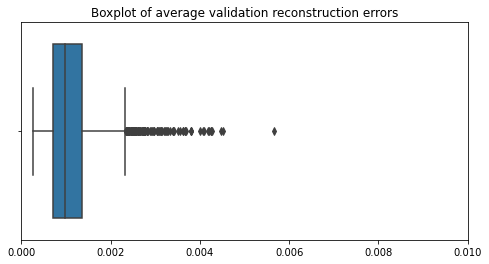

In [73]:
# plot distribution of average validation reconstruction errors
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.01])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.987)

Yhat3, errors3 = autoencoder.detect(X3, theta = theta , window = 12, average=True)
Yhat4, errors4 = autoencoder.detect(X4, theta = theta, window = 6, average=True)
Yhat5, errors5 = autoencoder.detect(X5, theta = theta, window = 1, average=True)

In [74]:
theta

0.003207734337661329

In [75]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02','test dataset GANS'],
                       columns = ['accuracy','f1_score','precision','recall'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)
results.loc['test dataset GANS'] = compute_scores(Y5,Yhat5)

print('Results:\n')
print(results)

Results:

                   accuracy  f1_score precision    recall
test dataset 01     0.95954  0.826667  0.834369  0.819106
test dataset 02     0.94112   0.84088  0.887978  0.798526
test dataset GANS  0.993308  0.992936  0.985972         1


In [76]:
# Get Results(Test Dataset 1)
precision, recall, f1, accuracy, specificity = classification_metrics(
    np.array(Y5), np.array(Yhat5))
print(f"Precision: {precision}")
print(f"Recall / True Positive Rate: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Specificity / True Negative Rate: {specificity}")

Precision: 0.9859719438877755
Recall / True Positive Rate: 1.0
F1 Score: 0.9929364278506558
Accuracy: 0.9933078393881453
Specificity / True Negative Rate: 0.9873646209386282


In [77]:
Yhat3

DATETIME
2016-07-04 00:00:00    False
2016-07-04 01:00:00    False
2016-07-04 02:00:00    False
2016-07-04 03:00:00    False
2016-07-04 04:00:00    False
                       ...  
2016-12-24 20:00:00    False
2016-12-24 21:00:00    False
2016-12-24 22:00:00    False
2016-12-24 23:00:00     True
2016-12-25 00:00:00     True
Length: 4177, dtype: bool

### Plot Figure

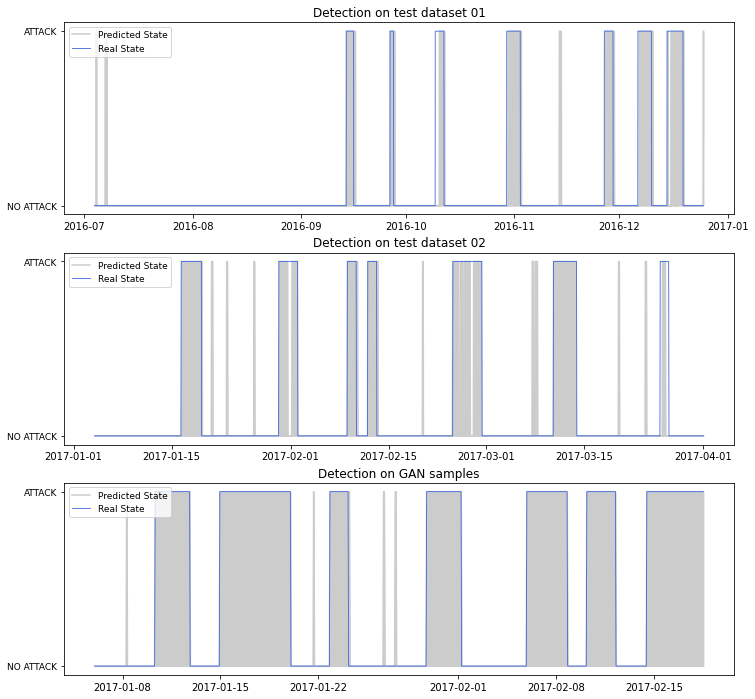

In [78]:
# plot figures
# shade_of_gray = '0.8'
# f, axes = plt.subplots(2,figsize = (20,15))
# axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
# axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
# axes[0].plot(Yhat3.index, Y3, color = 'r', alpha = 0.85, lw = 2, label = 'real state')
# axes[0].plot(errors3*15, label = "Scaled Reconstruction Errors")
# axes[0].set_title('Detection on test dataset 01', fontsize = 20)
# axes[0].set_yticks([0,1])
# axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 18)
# axes[0].legend(fontsize = 20, loc = 2)

# # axes[1].plot(errors3*20, label = "Scaled Reconstruction Errors")
# # axes[1].set_yticks([0,0.5])
# # axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

# axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
# axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
# axes[1].plot(Yhat4.index, Y4, color = 'r', alpha = 0.75, lw = 2, label = 'real state')
# axes[1].set_title('Detection on test dataset 02', fontsize = 20)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 18)
# axes[1].legend(fontsize = 20, loc = 2)

shade_of_gray = '0.8'
f, axes = plt.subplots(3,figsize = (12,12))
axes[0].plot(Yhat3, color = shade_of_gray, label = 'Predicted State')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Yhat3.index, Y3, color = 'royalblue', alpha = 0.85, lw = 1, label = 'Real State')
#axes[0].plot(errors3*15, color = 'k',alpha = 0.75, lw = 0.5, label = "Scaled Reconstruction Errors")
axes[0].set_title('Detection on test dataset 01', fontsize = 12)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[0].legend(fontsize = 9, loc = 2)

# axes[1].plot(errors3*20, label = "Scaled Reconstruction Errors")
# axes[1].set_yticks([0,0.5])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

axes[1].plot(Yhat4, color = shade_of_gray, label = 'Predicted State')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
axes[1].plot(Yhat4.index, Y4, color = 'royalblue', lw = 0.85, label = 'Real State')
axes[1].set_title('Detection on test dataset 02', fontsize = 12)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[1].legend(fontsize = 9, loc = 2)

axes[2].plot(Yhat5, color = shade_of_gray, label = 'Predicted State')
axes[2].fill_between(Yhat5.index, Yhat5.values, where=Yhat5.values <=1, interpolate=True, color=shade_of_gray)
axes[2].plot(Yhat5.index, Y5, color = 'royalblue',  lw = 0.85, label = 'Real State')
axes[2].set_title('Detection on GAN samples', fontsize = 12)
axes[2].set_yticks([0,1])
axes[2].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[2].legend(fontsize = 9, loc = 2)

plt.savefig('AE_GAN.png', dpi=300)

In [48]:
Yhat3

DATETIME
2016-07-04 00:00:00    False
2016-07-04 01:00:00    False
2016-07-04 02:00:00    False
2016-07-04 03:00:00    False
2016-07-04 04:00:00    False
                       ...  
2016-12-24 20:00:00    False
2016-12-24 21:00:00    False
2016-12-24 22:00:00    False
2016-12-24 23:00:00     True
2016-12-25 00:00:00     True
Length: 4177, dtype: bool

In [51]:
type(errors3)

pandas.core.series.Series

<AxesSubplot:xlabel='DATETIME'>

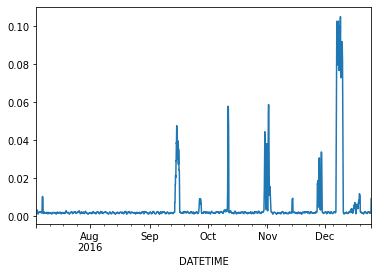

In [52]:
errors3.plot()
#plt.savefig('r.png', dpi=300)

<AxesSubplot:xlabel='DATETIME'>

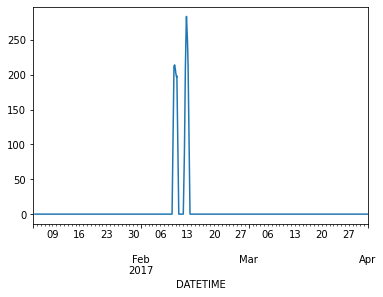

In [53]:
errors4.plot()

In [54]:
DF3 = validation_errors3
DF3["Attack"] = Y3
DF3["Preds"] = Yhat3
Yhat4

NameError: name 'validation_errors3' is not defined

### Reconstruction errors for each feature each instance (TestSet 1)

In [55]:
_, validation_errors3 = autoencoder.predict(X3)
#validation_errors3
DF3 = validation_errors3
DF3["Attack"] = Y3
DF3["Preds"] = Yhat3
DF3.to_csv(data_path + "validation_errors3.csv")

### Reconstruction errors for each feature each instance (TestSet 2)


In [56]:
_, validation_errors4 = autoencoder.predict(X4)
#validation_errors4
DF4 = validation_errors4
DF4["Attack"] = Y4
DF4["Preds"] = Yhat4
DF4.to_csv(data_path + "validation_errors4.csv")

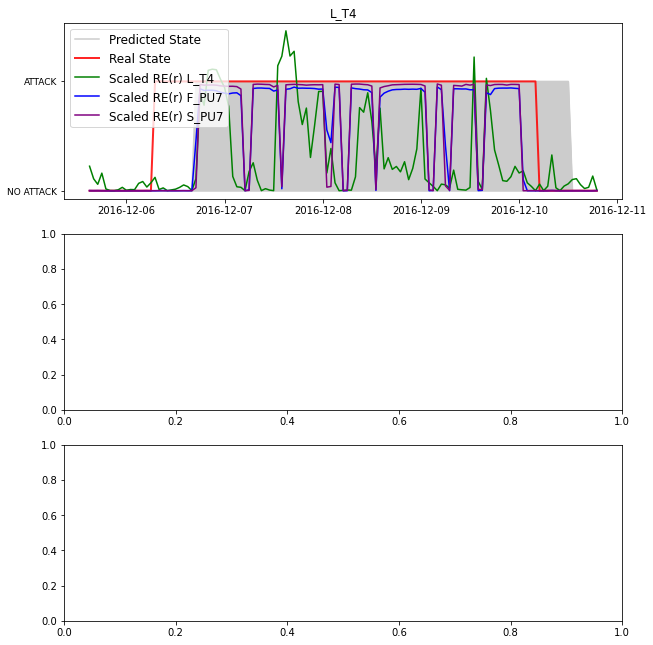

In [57]:

shade_of_gray = '0.8'
f, axes = plt.subplots(3,figsize = (10,11))
axes[0].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
axes[0].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
axes[0].plot(validation_errors3["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
axes[0].plot(validation_errors3["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7",color = 'blue')
axes[0].plot(validation_errors3["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7",color = 'purple')
axes[0].set_title('L_T4', fontsize = 12)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[0].legend(fontsize = 12, loc = 2)

# axes[1].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# axes[1].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# axes[1].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real Statee')
# axes[1].plot(validation_errors["F_PU7"][3711:3836], label = "Scaled RE(r)")
# axes[1].set_title('F_PU7', fontsize = 12)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
# axes[1].legend(fontsize = 12, loc = 2)

# axes[2].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# axes[2].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# axes[2].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
# axes[2].plot(validation_errors["S_PU7"][3711:3836], label = "Scaled RE(r)")
# axes[2].set_title('S_PU7', fontsize = 12)
# axes[2].set_yticks([0,1])
# axes[2].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
# axes[2].legend(fontsize = 12, loc = 2)

#plt.savefig('ALoc.png', dpi=300) 

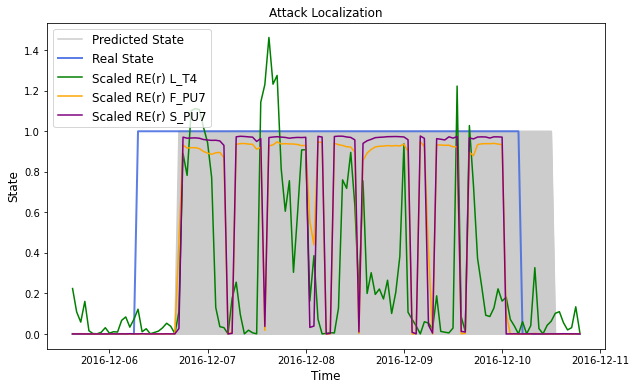

In [67]:
shade_of_gray = '0.8'
# plt.figure(figsize=(8,5))
# plt(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# plt.fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# plt(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
# plt(validation_errors["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
# plt(validation_errors["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7",color = 'blue')
# plt(validation_errors["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7",color = 'purple')
# # plt.title('L_T4', fontsize = 12)
# plt.yticks([0,1])
# plt.yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
#plt.legend(fontsize = 12, loc = 2)



plt.figure(figsize=(10,6))
plt.plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
plt.fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
plt.plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'royalblue', alpha = 0.85, lw = 2, label = 'Real State')
plt.plot(validation_errors3["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
plt.plot(validation_errors3["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7", color = 'orange')
plt.plot(validation_errors3["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7", color = 'purple')
plt.xlabel("Time", fontsize = 12)
plt.ylabel('State', fontsize = 12)
plt.title("Attack Localization", fontsize = 12)
plt.legend(labels=['Predicted State','Real State',"Scaled RE(r) L_T4","Scaled RE(r) F_PU7","Scaled RE(r) S_PU7"],fontsize = 12, loc = 2)
plt.savefig('ALoc.png', dpi=300)
plt.show()